# Recreating Figure 2: Dentategyrus

In [1]:
# to get everything set up, we need to install the following for visualizations
!pip install -U scvelo
!pip install python-igraph louvain
!pip install velocyto
!pip install gprofiler-official

In [32]:
# for plotting purposes, we need numpy and matplotlib
import numpy as np
import matplotlib.pyplot as pl

# the main tools we will be using is scVelo, a scalable toolkit for RNA velocity analysis in single cells
import scvelo as scv

# created a scvtools package for the plotting functions
from scvtools import utils

In [3]:
scv.settings.set_figure_params('scvelo')
scv.settings.plot_prefix = 'scvelo_fig2_'
scv.settings.verbosity = 2

In [4]:
# lets load the dentategyrus datasets
dentategyrus = scv.datasets.dentategyrus()

In [5]:
scv.pp.filter_and_normalize(dentategyrus, min_shared_cells=20, n_top_genes=2000)
scv.pp.moments(dentategyrus, n_neighbors=30, n_pcs=30)

Filtered out 11835 genes that are detected in less than 20 cells (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:06)
computing moments based on connectivities
    finished (0:00:00)


In [6]:
scv.tl.velocity(dentategyrus, vkey='steady_state_velocity', mode='steady_state')
scv.tl.velocity_graph(dentategyrus, vkey='steady_state_velocity')

scv.tl.velocity(dentategyrus, vkey='stochastic_velocity', mode='stochastic')
scv.tl.velocity_graph(dentategyrus, vkey='stochastic_velocity')


computing velocities
    finished (0:00:00)
computing velocity graph (using 1/8 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:04)
computing velocities
    finished (0:00:00)
computing velocity graph (using 1/8 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:04)


In [7]:
# this will take a while to load (around 6 minutes) 
scv.tl.recover_dynamics(dentategyrus)

recovering dynamics (using 1/8 cores)


  0%|          | 0/930 [00:00<?, ?gene/s]

    finished (0:04:39)


In [8]:
scv.tl.velocity(dentategyrus, mode='dynamical', vkey='dynamical_velocity')
scv.tl.velocity_graph(dentategyrus, vkey='dynamical_velocity', variance_stabilization=True)

computing velocities
    finished (0:00:02)
computing velocity graph (using 1/8 cores)


  0%|          | 0/2930 [00:00<?, ?cells/s]

    finished (0:00:07)


computing velocity embedding
    finished (0:00:00)


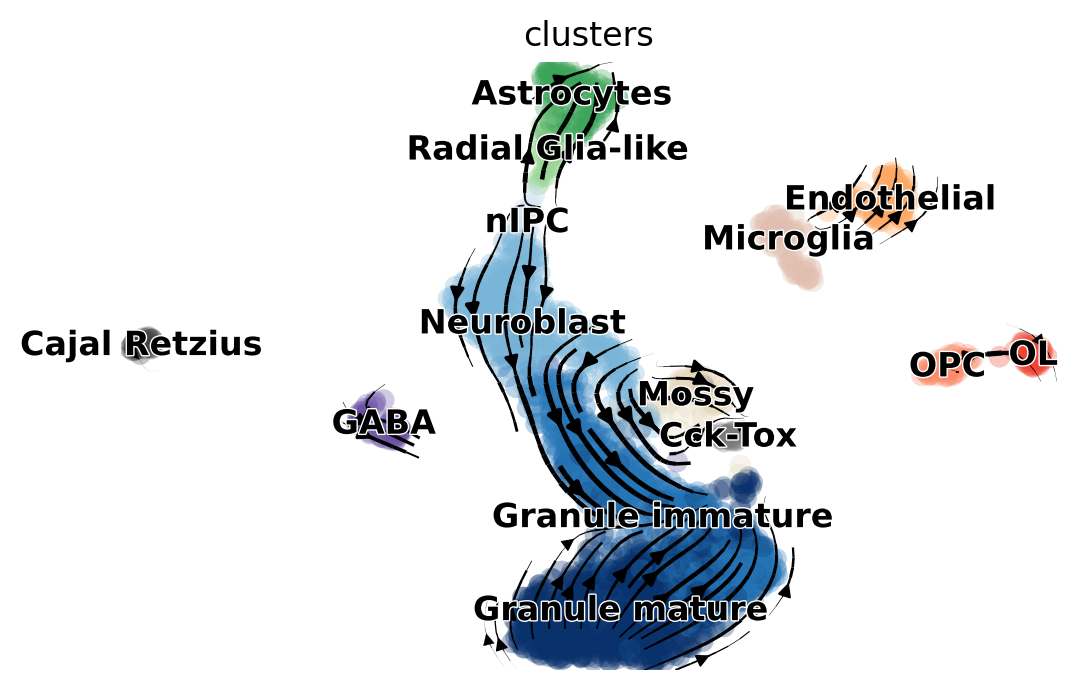

In [9]:
scv.pl.velocity_embedding_stream(dentategyrus, vkey='dynamical_velocity')

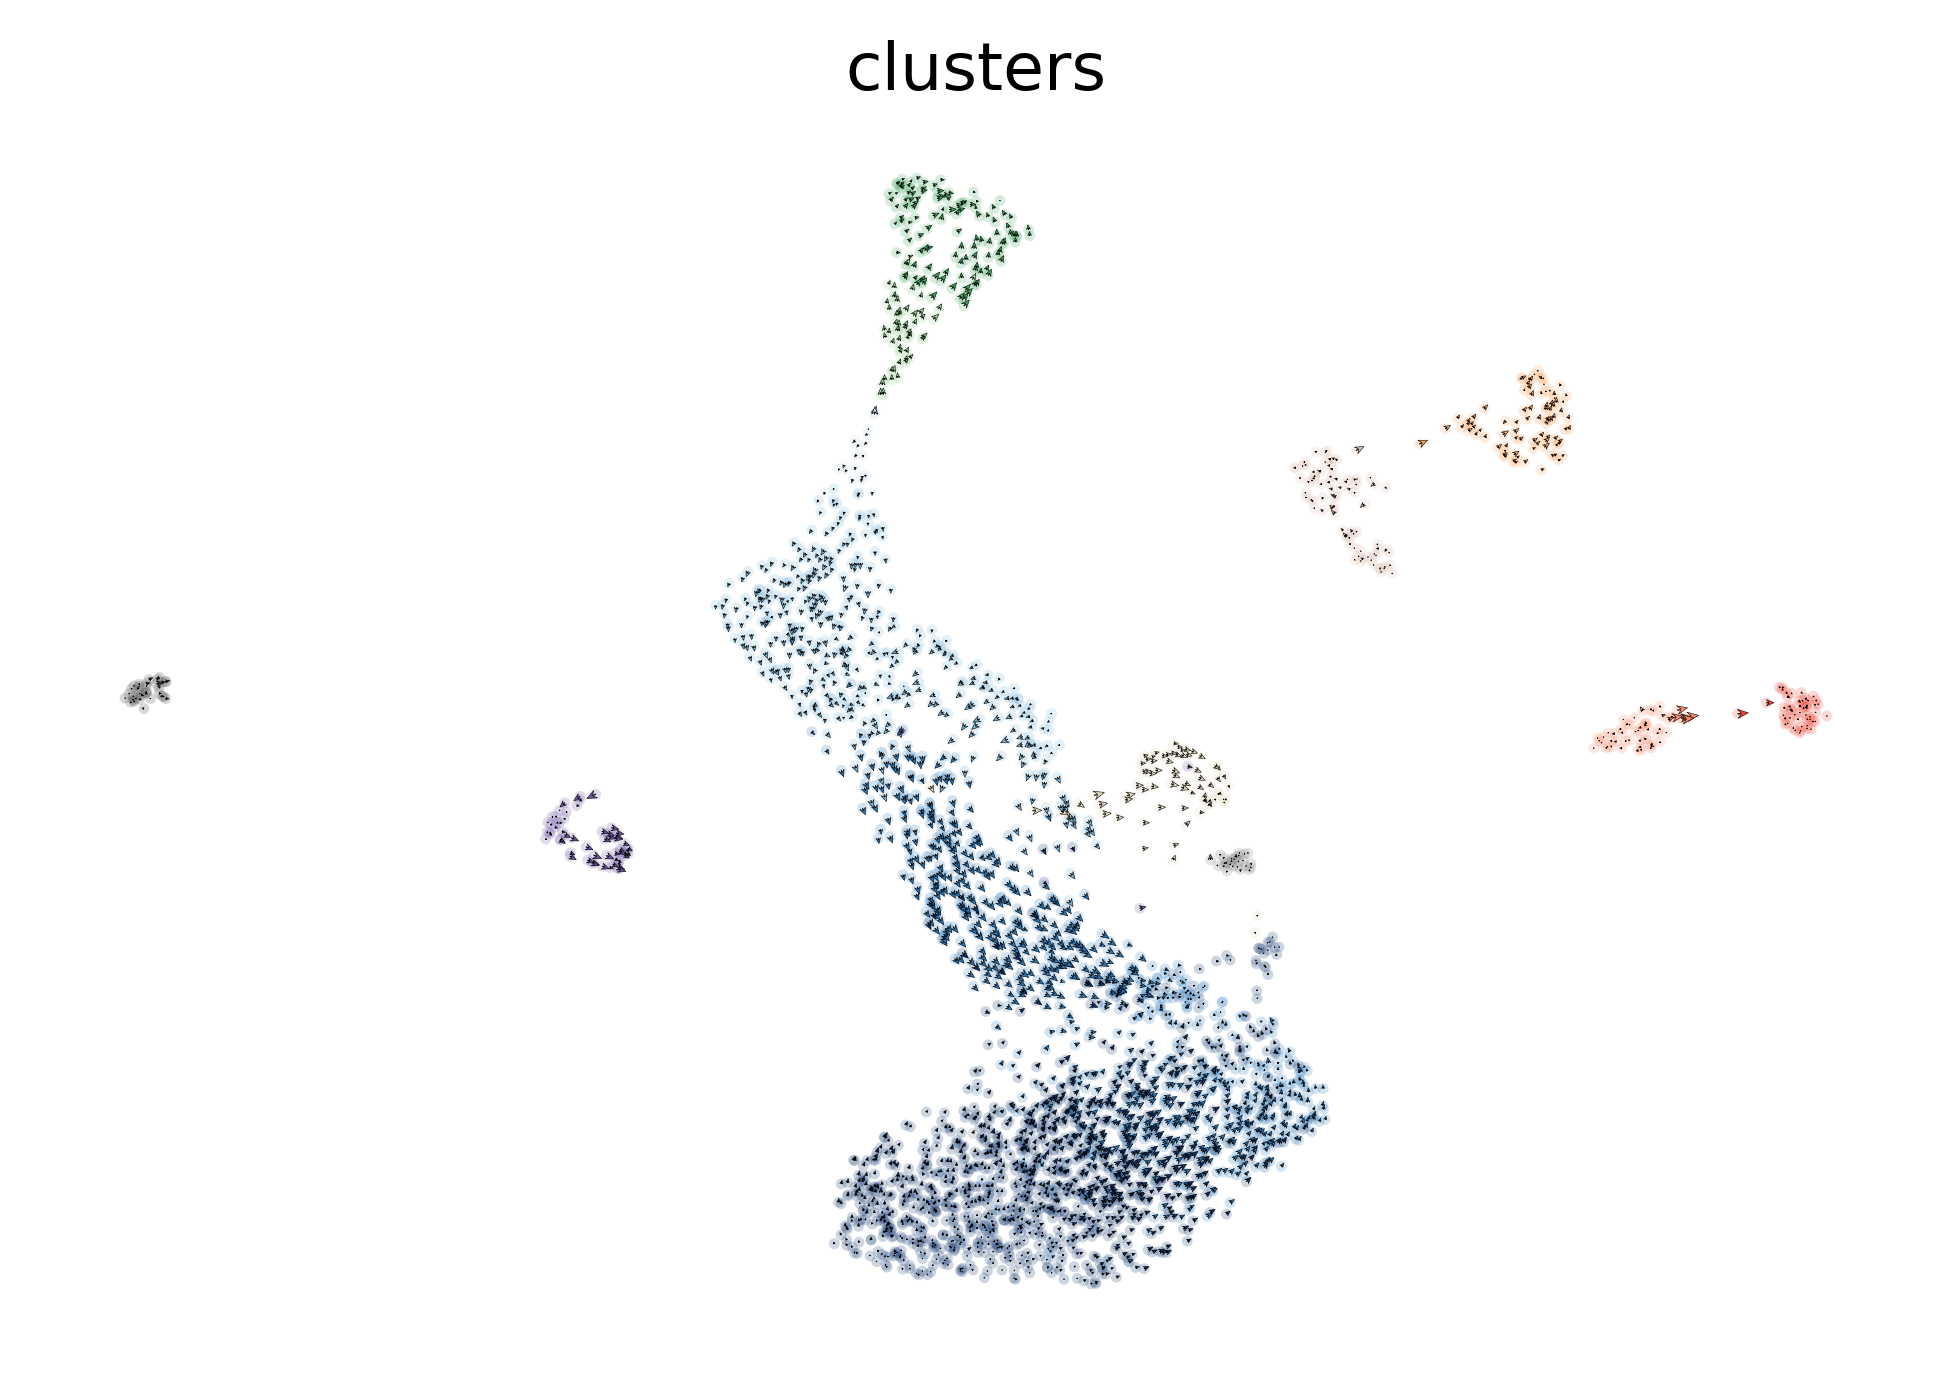

In [10]:
scv.pl.velocity_embedding(dentategyrus, vkey='dynamical_velocity', scale=.7, dpi=200)

In [11]:
vlm = scv.utils.convert_to_loom(scv.datasets.dentategyrus())

In [12]:
vlm = scv.utils.convert_to_loom(scv.datasets.dentategyrus())

vlm.score_detection_levels(min_expr_counts=20, min_expr_counts_U=20)
vlm.filter_genes(by_detection_levels=True)

vlm.score_cv_vs_mean(2000)
vlm.filter_genes(by_cv_vs_mean=True)

vlm._normalize_S(relative_size=vlm.initial_cell_size, target_size=np.median(vlm.initial_cell_size))
vlm._normalize_U(relative_size=vlm.initial_Ucell_size, target_size=np.median(vlm.initial_Ucell_size))

vlm.S_norm = np.log1p(vlm.S_sz)

vlm.perform_PCA(n_components=30)
vlm.knn_imputation(n_pca_dims=30, k=30)
vlm.normalize_median()

vlm.fit_gammas(fit_offset=False)
#vlm.filter_genes_good_fit()

vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift()
vlm.extrapolate_cell_at_t()

vlm.estimate_transition_prob(hidim='Sx_sz', emebed='ts', transform='sqrt', )
vlm.calculate_embedding_shift(sigma_corr=.05, expression_scaling=False, )

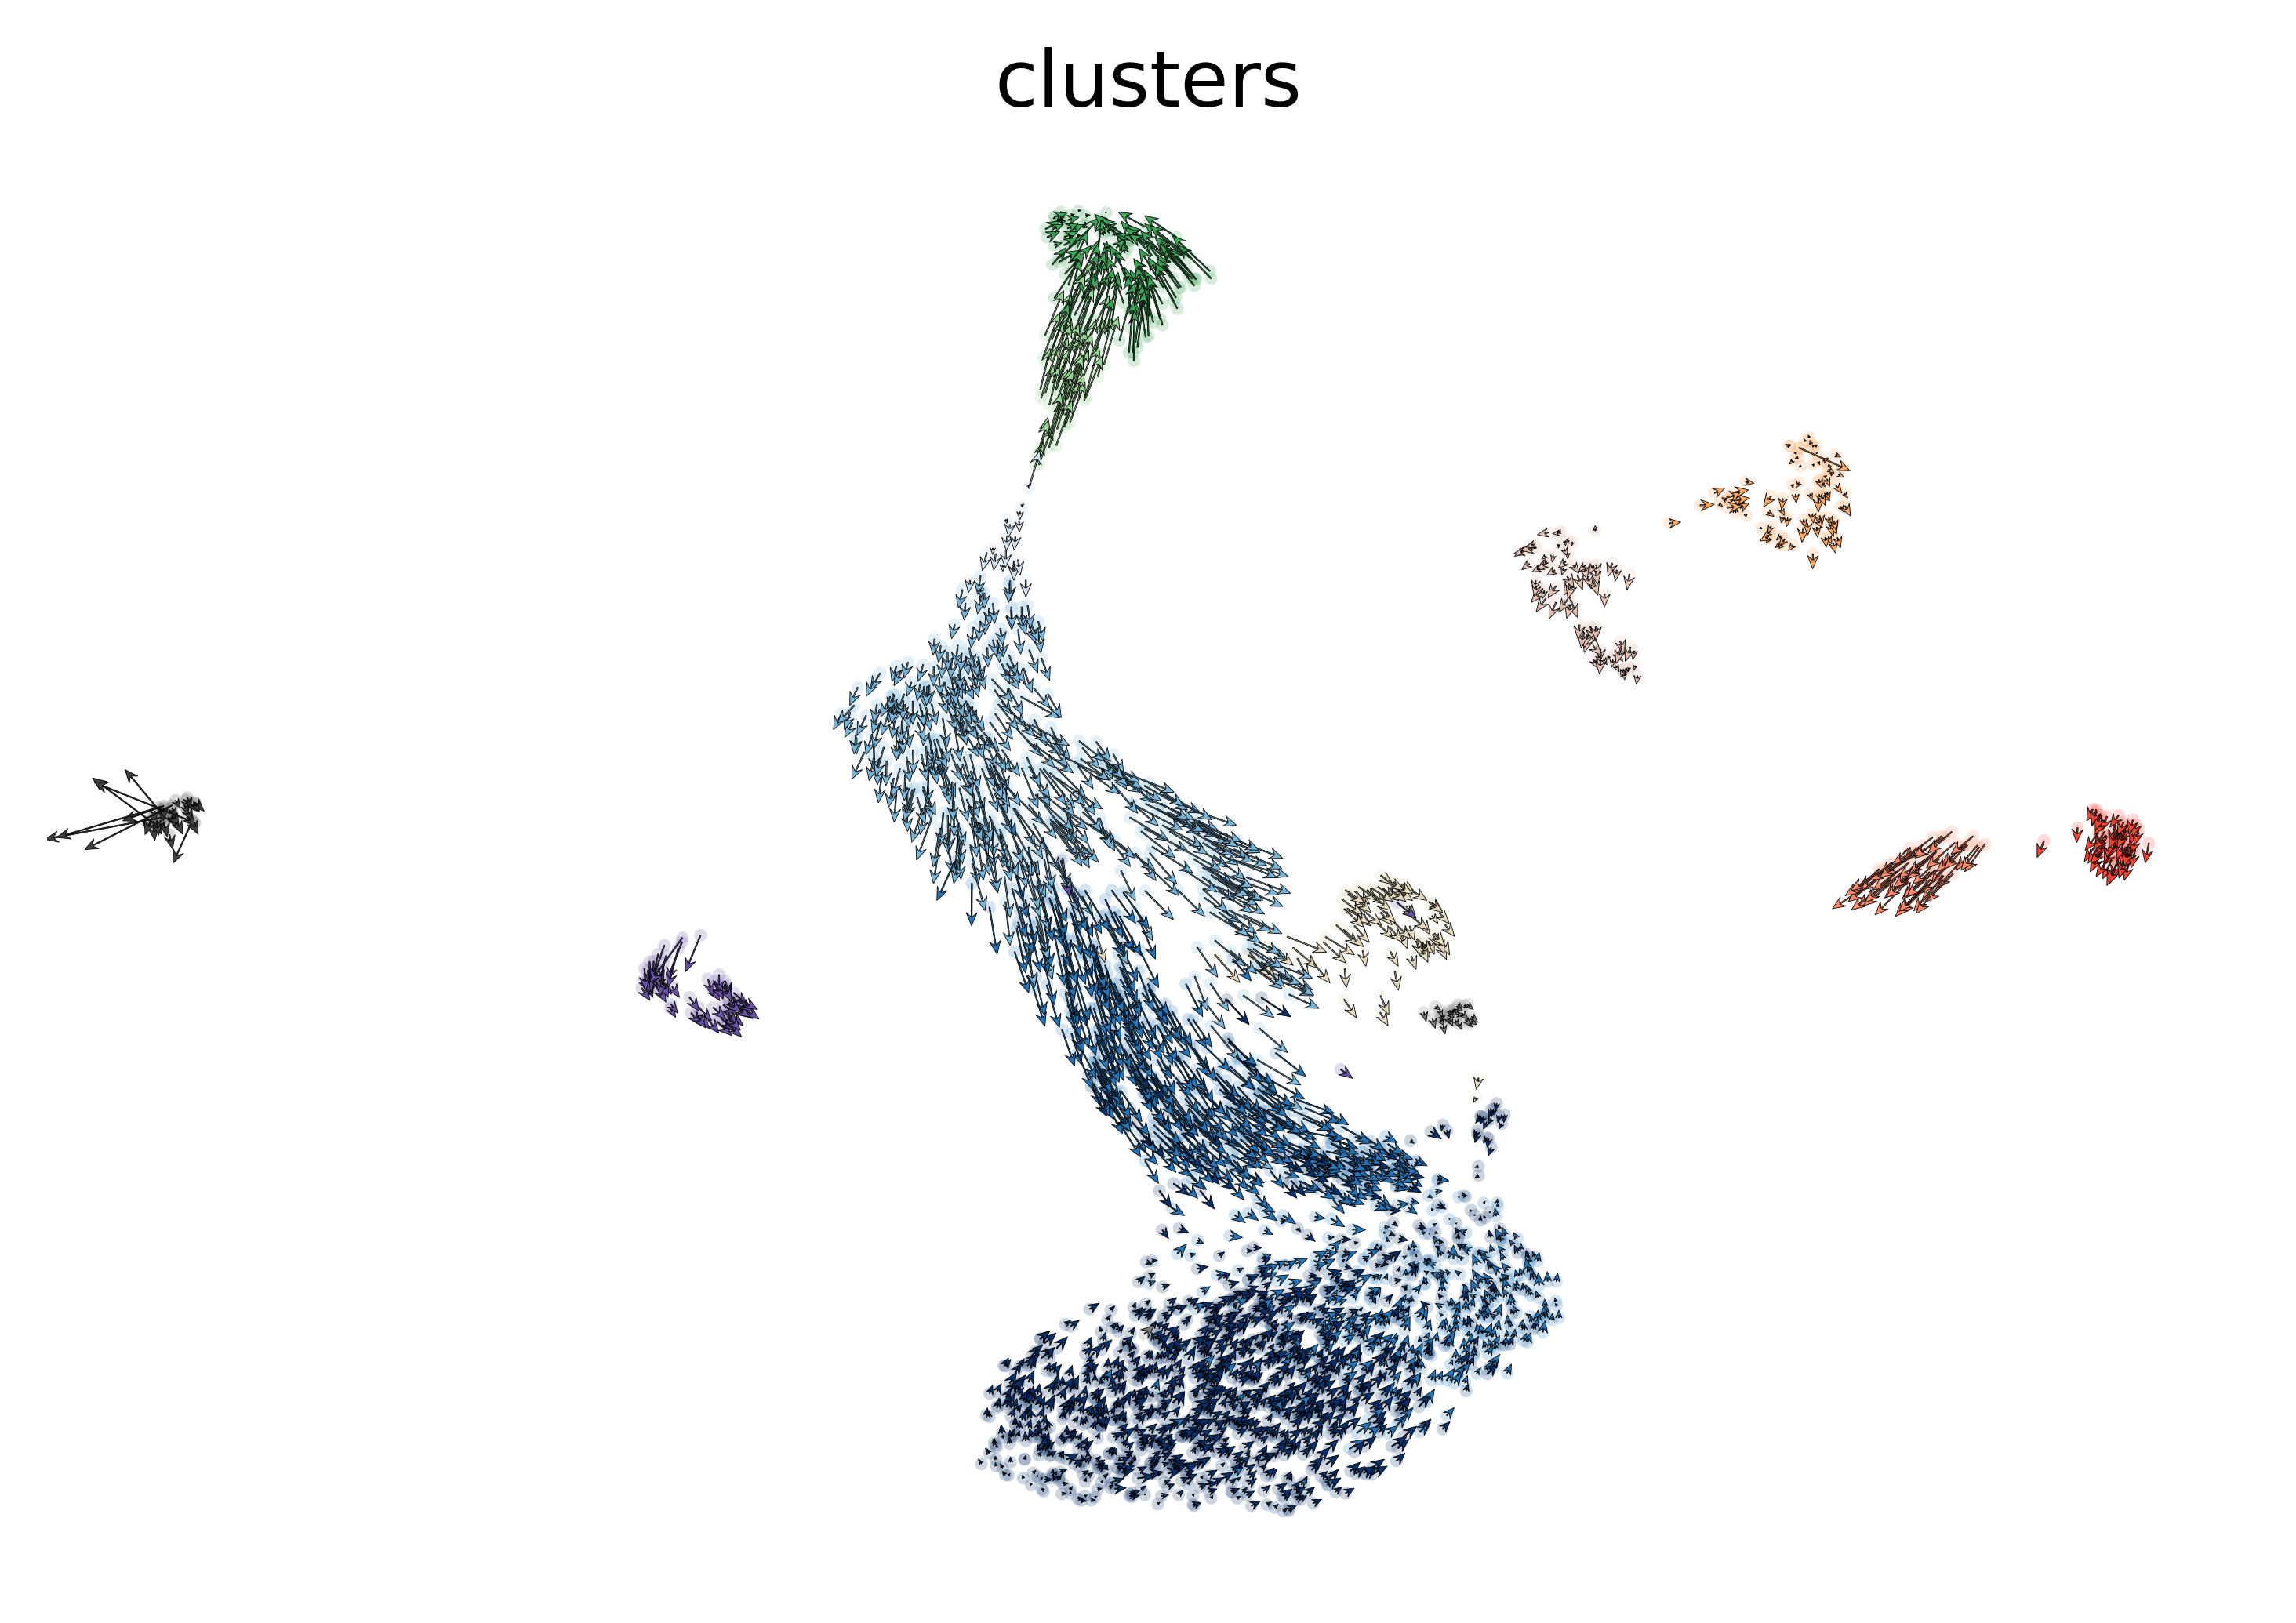

In [13]:
scv.pl.velocity_embedding(dentategyrus, X=vlm.embedding, V=vlm.delta_embedding, frameon=False, dpi=300)

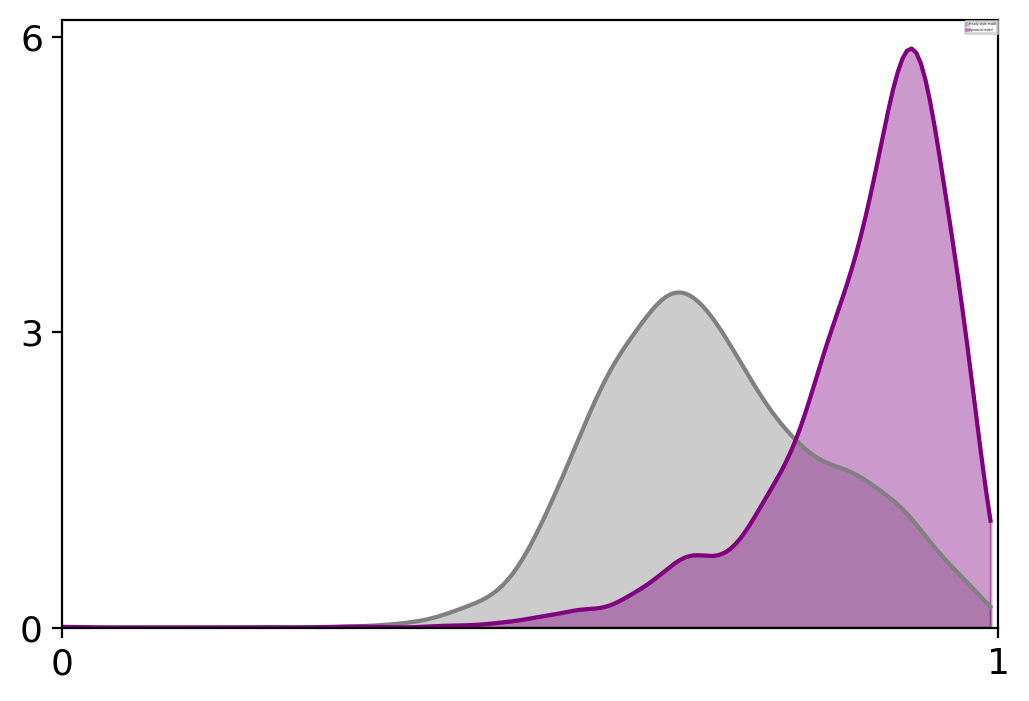

In [14]:
vkey_ss = 'steady_state_velocity'
vkey_sm = 'stochastic_velocity'
vkey_dm = 'dynamical_velocity'

scv.tl.velocity_confidence(dentategyrus, vkey=vkey_ss)
scv.tl.velocity_confidence(dentategyrus, vkey=vkey_sm)
scv.tl.velocity_confidence(dentategyrus, vkey=vkey_dm)

scv.pl.hist([dentategyrus.obs[vkey_ss + '_confidence'].values, 
             dentategyrus.obs[vkey_dm + '_confidence'].values],
            labels=['steady-state model', 'dynamical model'], kde=True, colors=['grey', 'purple'],
            bins=200, xlim=[0, 1], fontsize=18, legend_fontsize=1)

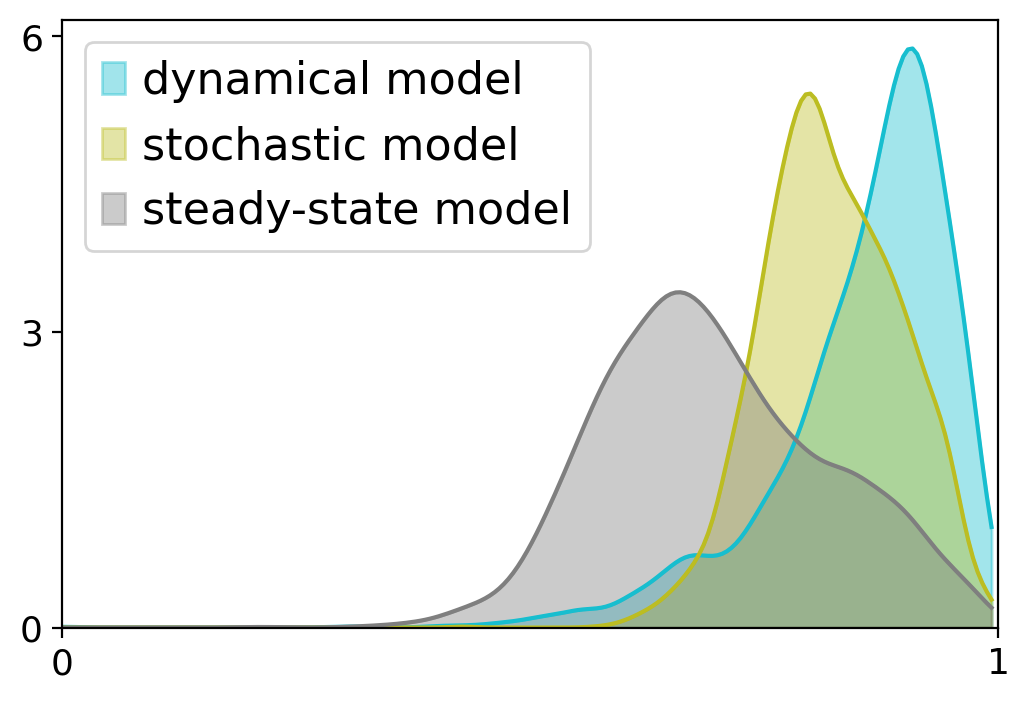

In [15]:
scv.pl.hist([dentategyrus.obs[vkey_dm + '_confidence'].values, 
             dentategyrus.obs[vkey_sm + '_confidence'].values,
             dentategyrus.obs[vkey_ss + '_confidence'].values], 
            labels=['dynamical model', 'stochastic model', 'steady-state model'], kde=True, 
            bins=200, xlim=[0, 1], fontsize=18, legend_fontsize=16)

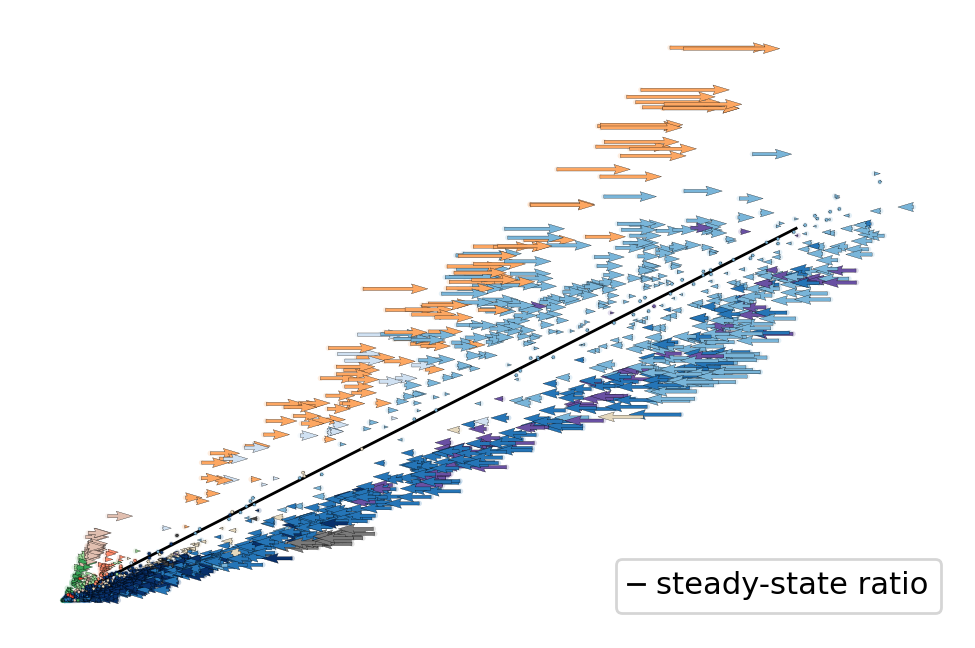

In [16]:
scv.pl.velocity_embedding(dentategyrus, vkey='steady_state_velocity', basis='Tmsb10', 
                          scale=.6, width=.0035, frameon=False, title='')

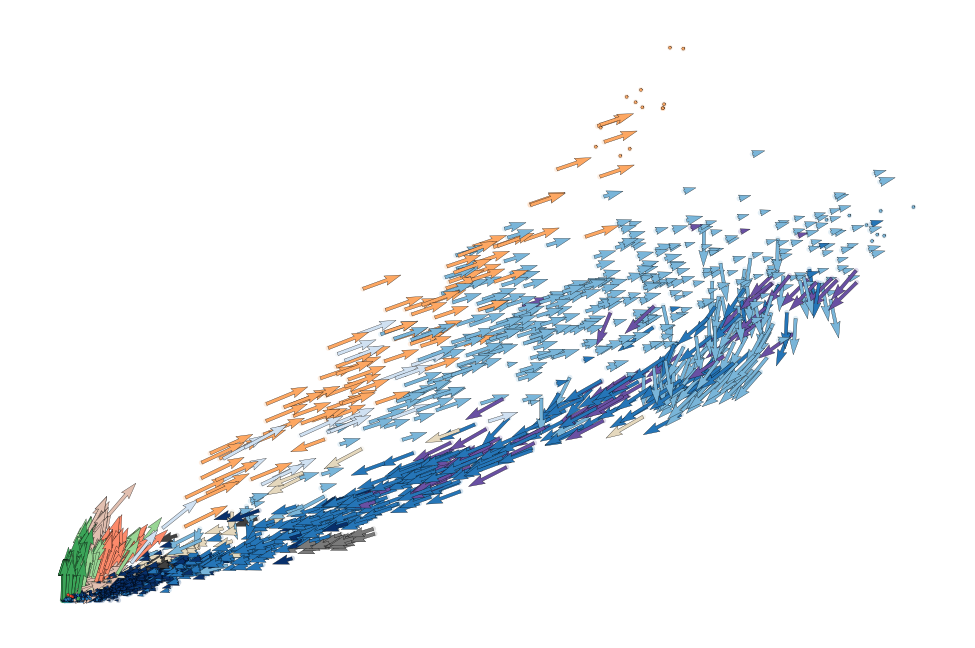

In [17]:
scv.pl.velocity_embedding(dentategyrus, vkey='dynamical_velocity', basis='Tmsb10', scale=4, width=.0035,
                         frameon=False, title='')

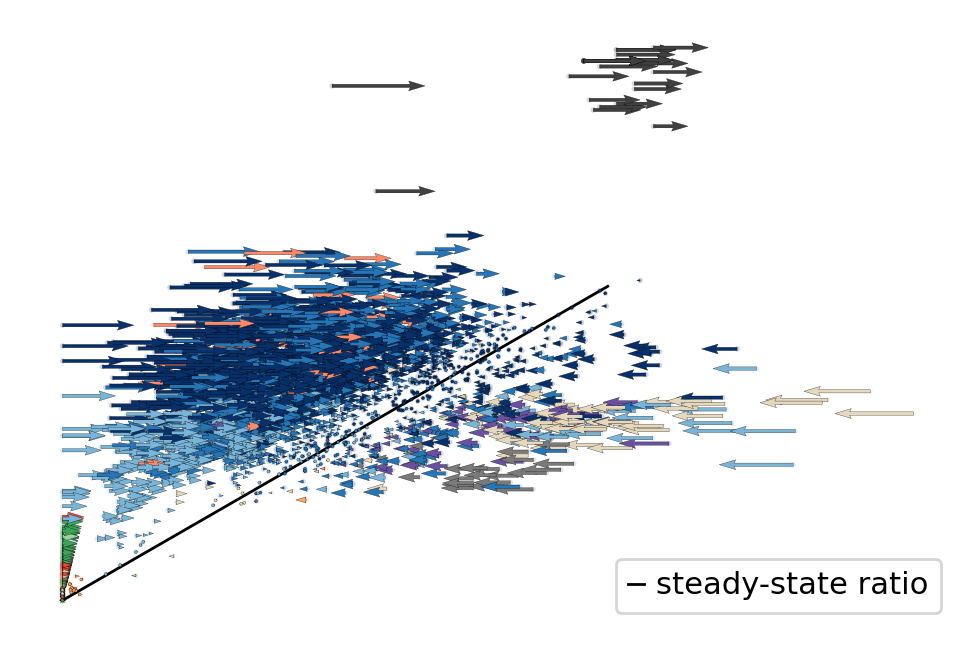

In [18]:
scv.pl.velocity_embedding(dentategyrus, vkey='steady_state_velocity', basis='Fam155a', 
                          scale=60, width=.0035, frameon=False, title='')

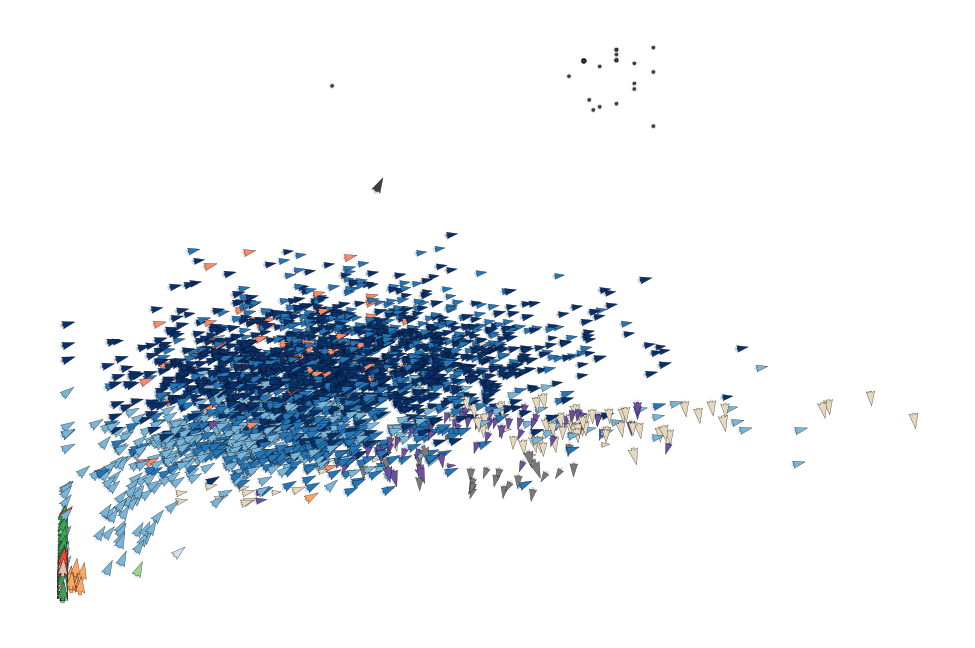

In [19]:
scv.pl.velocity_embedding(dentategyrus, vkey='dynamical_velocity', basis='Fam155a', 
                          scale=3, width=.0035, frameon=False, title='')

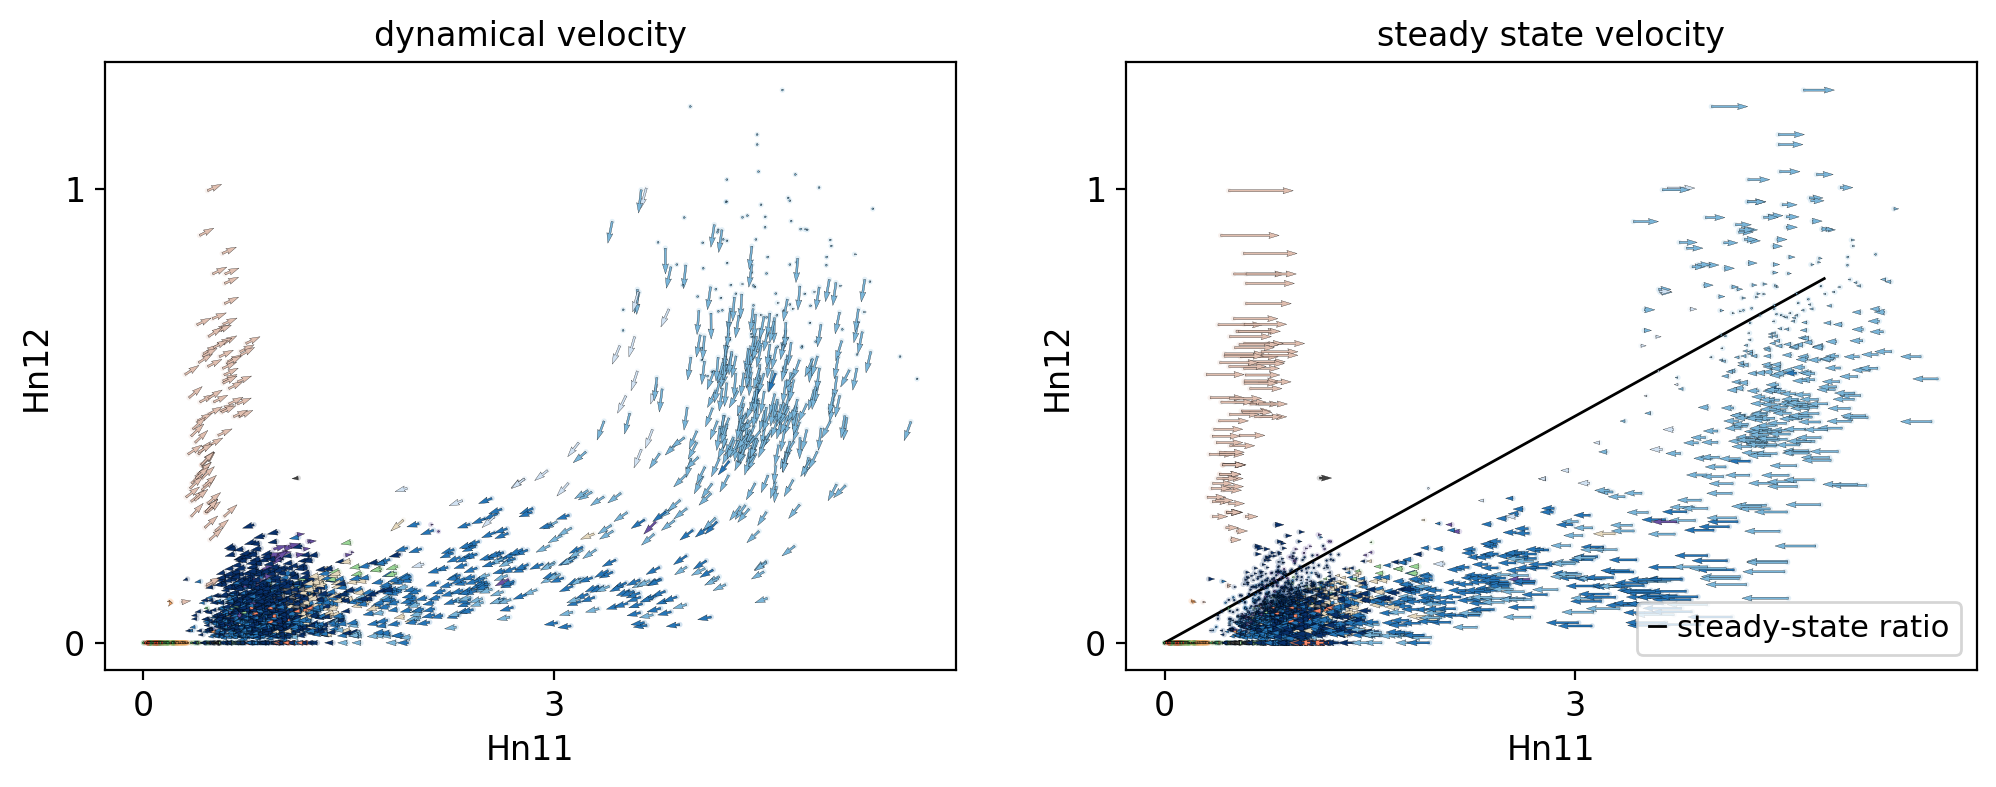

In [20]:
gene = 'Hn1'
scv.pl.velocity_embedding(dentategyrus, basis=gene, vkey=['dynamical_velocity', 'steady_state_velocity'])

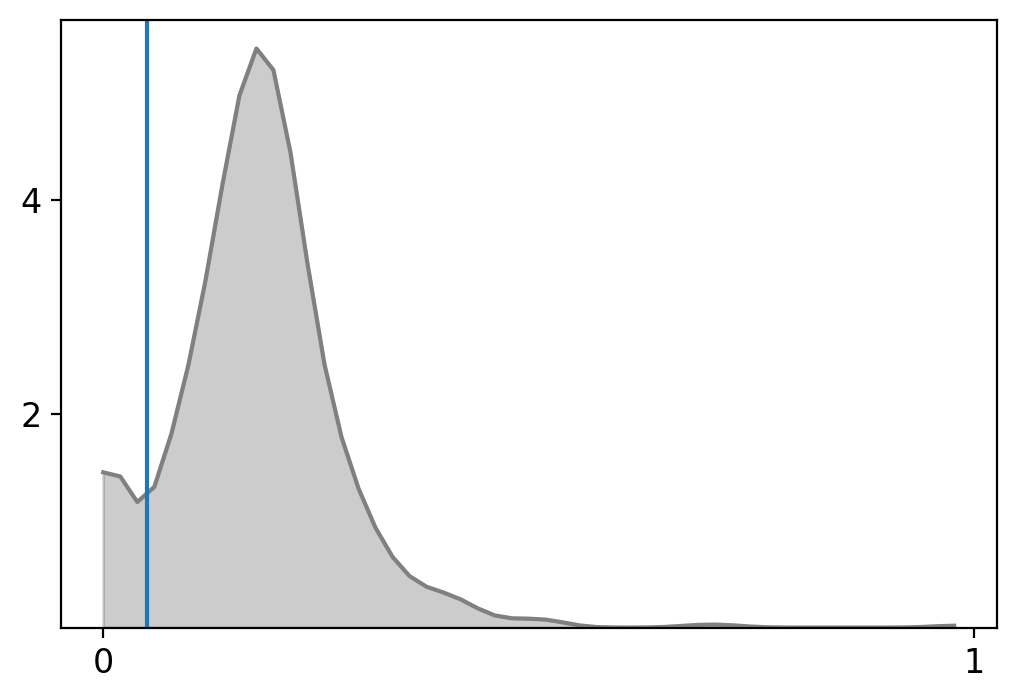

In [21]:
scv.pl.hist(dentategyrus.var['fit_likelihood'], axvline=.05, kde=True, exclude_zeros=True, colors=['grey'])

# plotting dynamic driving genes and non-dynamic genes

In [22]:
# created a scvtools package for the plotting functions
from scvtools import utils

In [23]:
utils.recover_dynamics(dentategyrus, ['Tmsb10', 'Ppp3ca', 'Hn1', 'Dlg2'])

recovering dynamics (using 1/8 cores)
    finished (0:00:03)

outputs model fit of gene: Dlg2


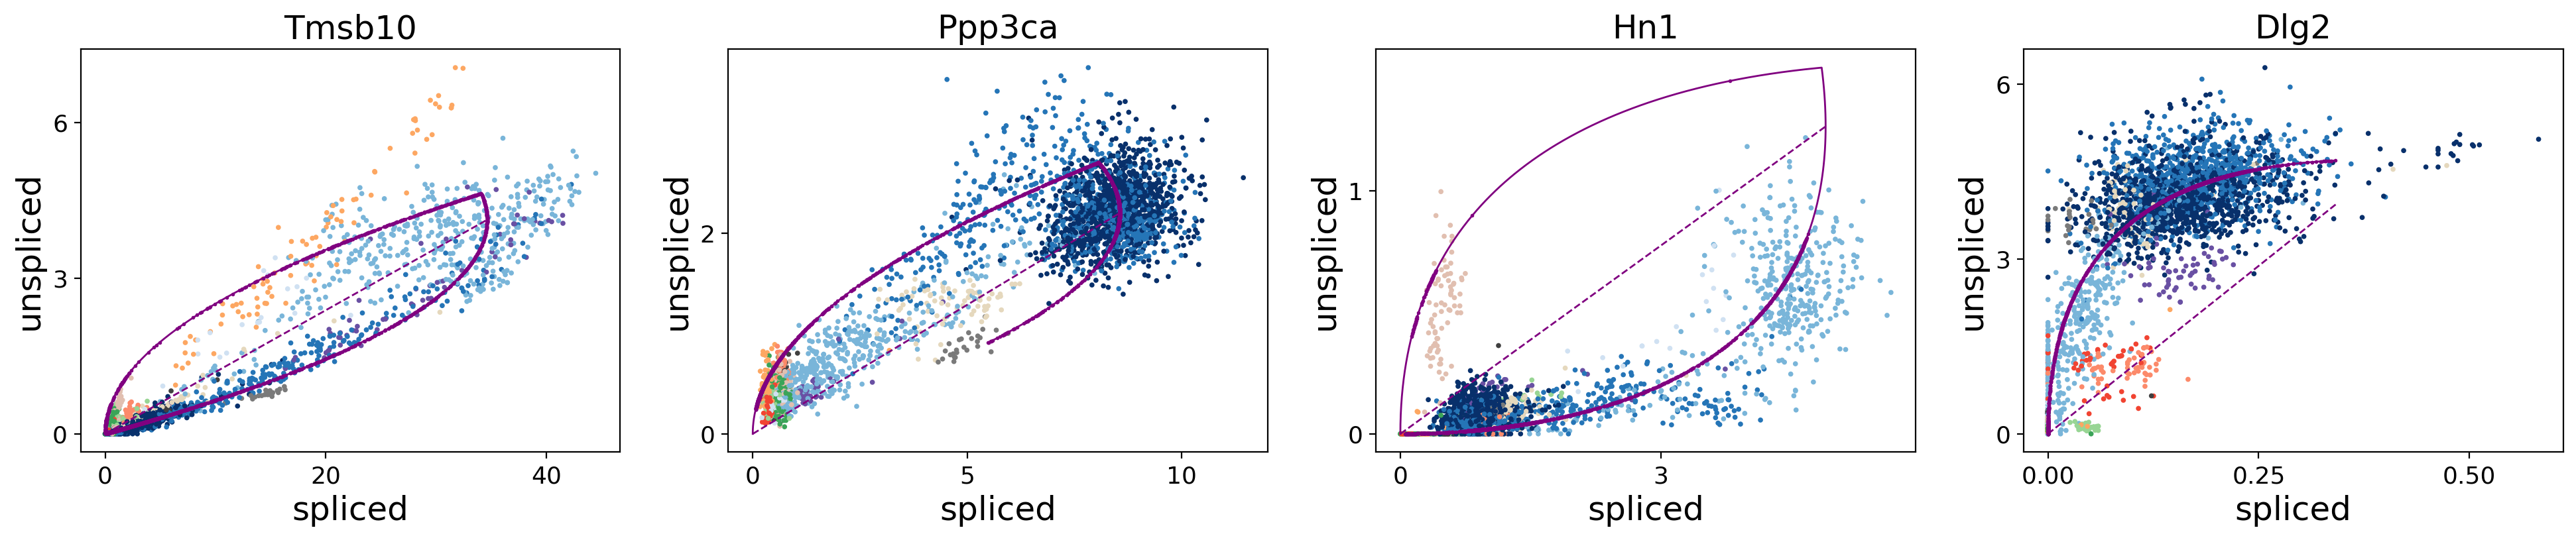

In [24]:
# changed basis by creating a variable and deleting the parameters
basis_dynamic = ['Tmsb10', 'Ppp3ca', 'Hn1', 'Dlg2']
utils.plot_genes(dentategyrus, basis_dynamic)

recovering dynamics (using 1/8 cores)
    finished (0:00:01)

outputs model fit of gene: Tmsb10


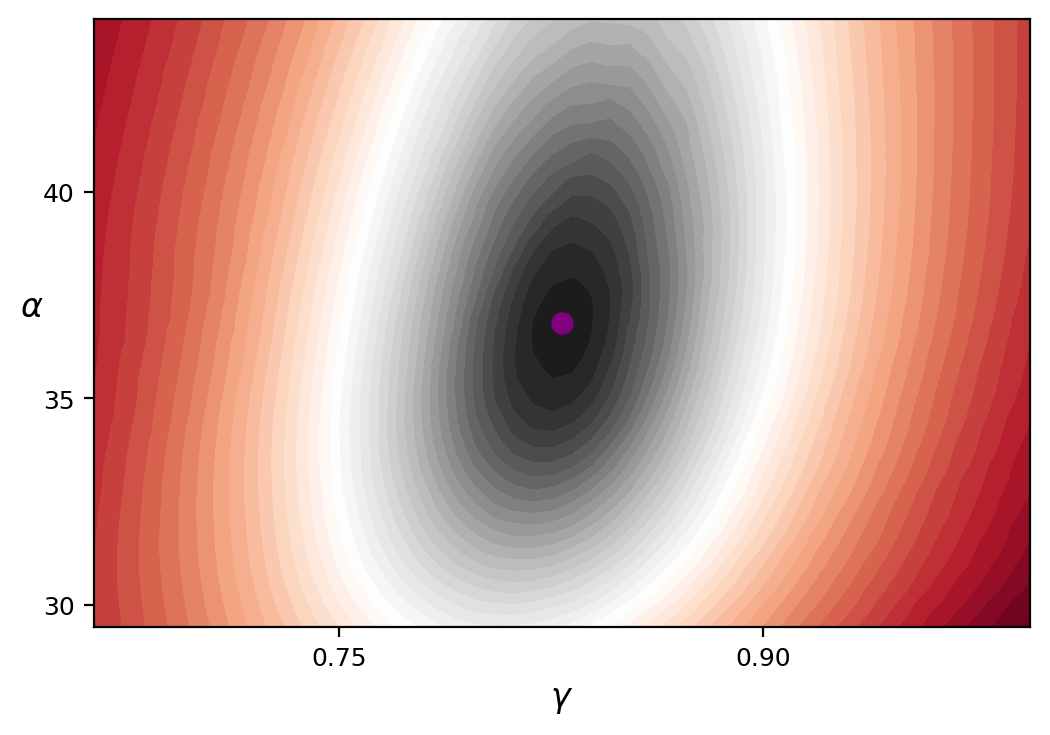

In [25]:
utils.plot_contour(dentategyrus, 'Tmsb10', 100, .2, .2, 0, 50)

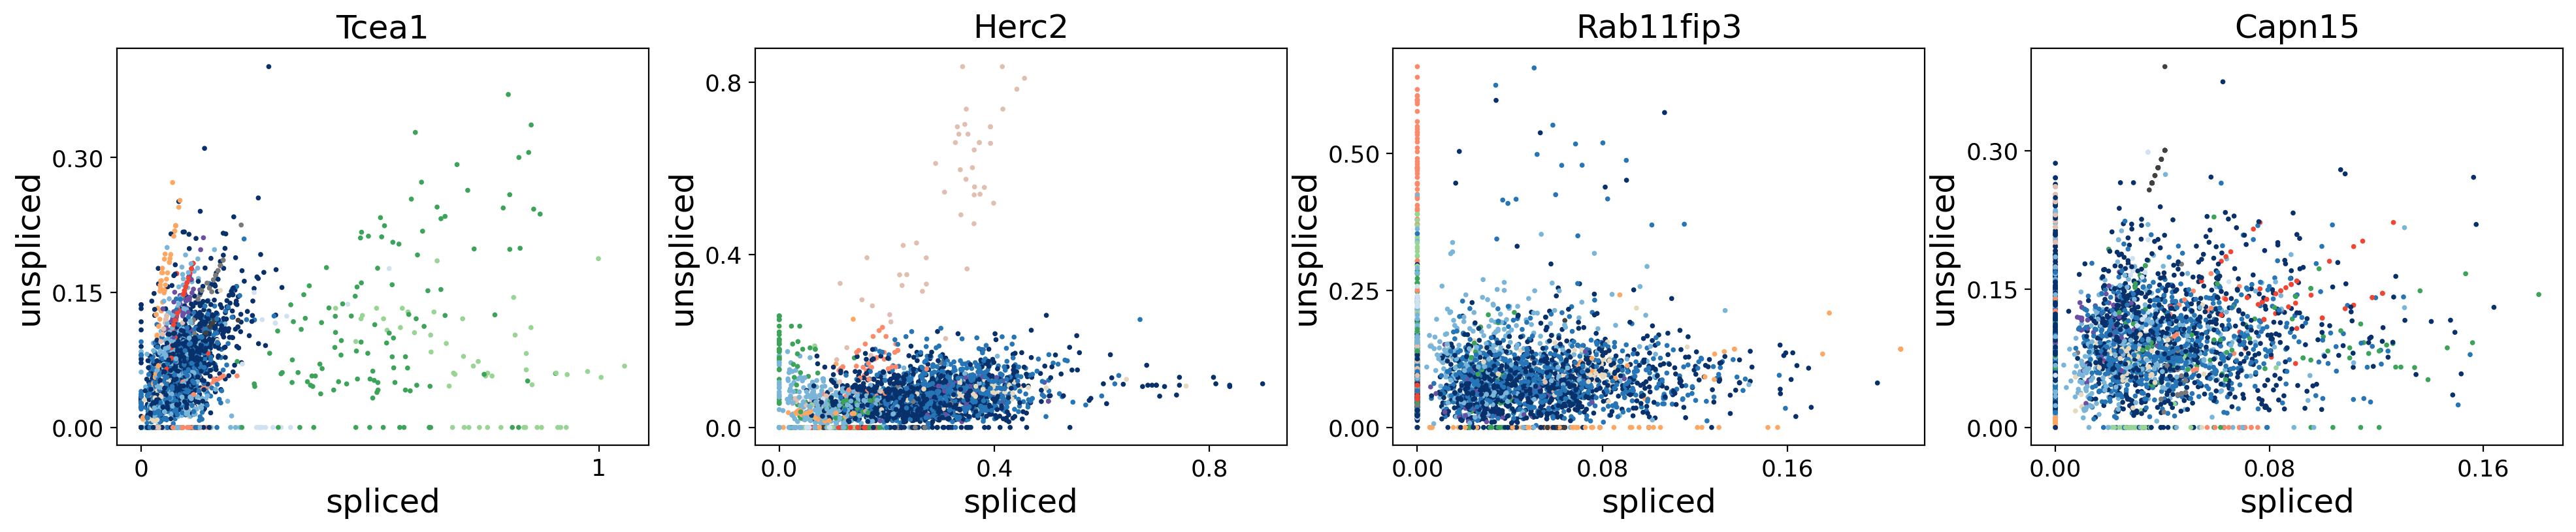

In [26]:
# changed basis by creating a variable and deleting the parameters
basis_non_dynamic = ["Tcea1", "Herc2", "Rab11fip3", "Capn15"]
utils.plot_genes(dentategyrus, basis_non_dynamic)

recovering dynamics (using 1/8 cores)
    finished (0:00:00)

outputs model fit of gene: Tcea1


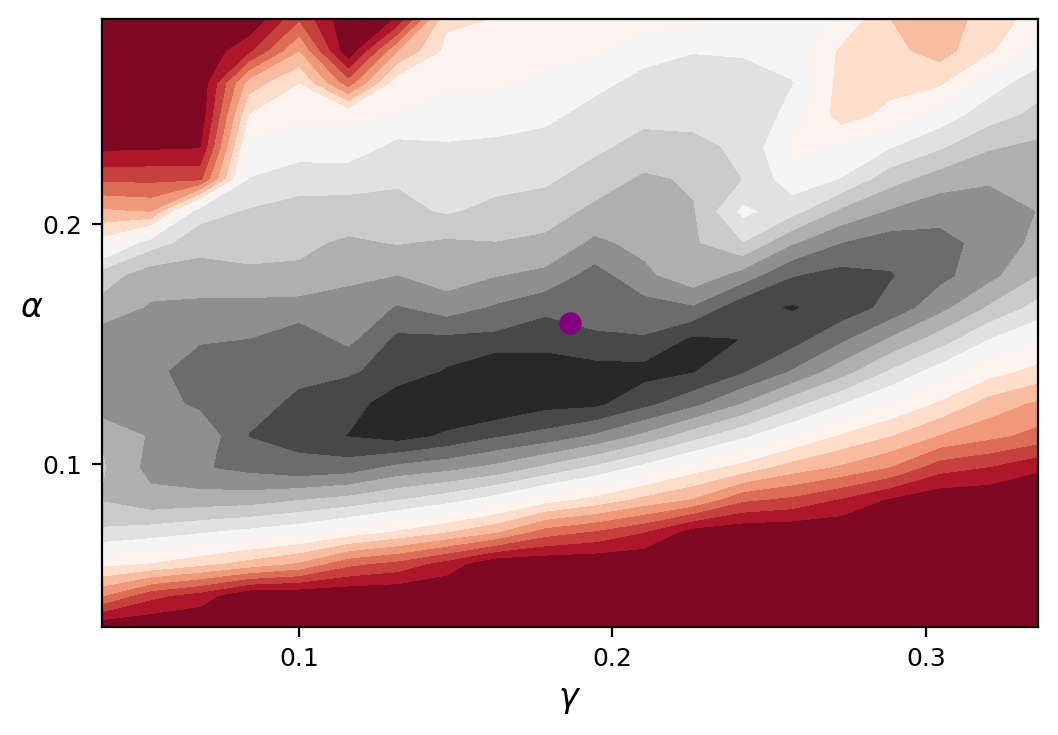

In [27]:
utils.plot_contour(dentategyrus, 'Tcea1', 10, .8, .8, 0, 20)

In [33]:
# validation of top likelihood genes
utils.plot_validation_likelihood(dentategyrus)

NameError: name 'np' is not defined

In [ ]:
sdata = dentategyrus[:, dentategyrus.var_names.isin(top_genes[:10])].copy()
scv.tl.velocity_graph(sdata, vkey='dynamical_velocity')
scv.pl.velocity_embedding_stream(sdata, vkey='dynamical_velocity')

In [ ]:
sdata = dentategyrus[:, ~dentategyrus.var_names.isin(top_genes[:30])].copy()
scv.tl.velocity_graph(sdata, vkey='dynamical_velocity')
scv.pl.velocity_embedding_stream(sdata, vkey='dynamical_velocity')

In [ ]:
from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True, user_agent='g:GOSt')

neuro_enrichment = gp.profile(query=list(top_genes[:100]), background=list(dentategyrus.var_names),
                              organism='mmusculus', sources=['KEGG'], significance_threshold_method='fdr')

In [ ]:
neuro_enrich_results = neuro_enrichment.set_index('native').sort_values('p_value').iloc[:,[2,5,7,10,1]]
neuro_enrich_results.iloc[:100,:]

In [ ]:
scv.pl.velocity_embedding_stream(dentategyrus, vkey='steady_state_velocity', title='', legend_loc='none', 
                                 alpha=.3, legend_fontsize=12, arrow_color='darkslategrey', 
                                 density=.9, linewidth=1, min_mass=2)

In [ ]:
kwargs = {'fontsize': 18, 'size': 80, 'title': '', 
          'legend_loc': 'none', 'colorbar': False, 'frameon': False}
basis = 'Tmsb10'

In [ ]:
dm = scv.tl.recover_dynamics(dentategyrus, var_names='Tmsb10')

In [ ]:
ax = dm.plot_state_likelihoods(var_scale=None, dpi=120)

In [ ]:
scv.tl.recover_dynamics(dentategyrus, var_names=var_names)
scv.tl.velocity(dentategyrus, mode='dynamical', vkey='dynamical_velocity', normalized=True)

In [ ]:
var_names=['Lrrc7', 'Hn1', 'Tmsb10', 'Rnf138', 'Tnr']

scv.pl.velocity_embedding(dentategyrus, basis=var_names, vkey='steady_state_velocity')
scv.pl.velocity_embedding(dentategyrus, basis=var_names, vkey='dynamical_velocity')

In [ ]:
dm = scv.tl.recover_dynamics(dentategyrus, var_names='Tmsb10')
dm.plot_profiles(fontsize=16, dpi=120)

In [ ]:
dm = scv.tl.recover_dynamics(dentategyrus, var_names='Ppp3ca')
dm.plot_profiles(fontsize=16, dpi=120)